# **Dow Jones index replication with portfolio optimization methods**

The **Dow Jones Industrial Average** ("^DJI", hereinafter) is a popular stock market index that gathers 30 prominent companies listed in the U.S. stock exchanges. [Check here for general knowledge](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average) and [here for the technical details](https://www.spglobal.com/spdji/en/documents/methodologies/methodology-dj-averages.pdf).



# The problem

Just like single stocks, stock market indexes also yield a return (positive or negative) over time. Whenever an investor wants to match exactly an index return, he/she needs to buy all the underlying stocks. This can be **considerably costly due to transaction commissions**, especially for indexes that contain hundreds of different stocks.

To overcome this problem, the investor needs to create a portfolio containing a smaller number of stocks whose aggregate return is as similar as possible to the index he/she wants to replicate. In this way, the investor can ensure a **higher overall performance simply by reducing the commission costs**.

Of course, there are limits to this kind of simplification. **The higher the number of stocks excluded from the portfolio, the higher the deviation of the portfolio return** compared to the original index (unless some of those stocks are negatively correlated with the index). This trade-off is at the core of every portfolio optimization project.

# Premise considerations
Due to some peculiarities of this project, here I list the simplifications I am taking for granted in the current version. Some of them may be considered in future versions.

*   A pool of experts changes the ^DJI stock composition periodically. For simplicity, **I will consider only the time period from the last update (August 31st 2020) to May 31st 2023**. The briefness of the time period is evident also by looking at the portfolios Betas, which are exceptionally small. A much more valuable approach would take a wider time range (20-30 years) and would adjust the portfolio composition dynamically along with the index updates. [For the historical components of the ^DJI check here](https://en.wikipedia.org/wiki/Historical_components_of_the_Dow_Jones_Industrial_Average).

*   The official ^DJI close is calculated by summing all the close prices of the stocks comprised in the index and dividing by a constant, the Dow Divisor. The purpose of the Dow Divisor is to ensure that extraordinary events like stock splits, spinoffs or other structural changes, do not in themselves alter the numerical value of the ^DJI. The Dow Divisor is periodically updated too, **I will take for granted the latest Dow Divisor (issued on November 4th 2021) for the entirety of the project period**. As for the previous assumption, a more solid approach would dynamically change the Dow Divisor when every update has been published. [For the historical Dow Divisors check here](https://www.barrons.com/market-data/market-lab?mod=md_subnav).

*   Every proper portfolio optimization strategy has periodical (monthly or trimestral) checkpoint buckets to evaluate the goodness of the replica and make some rebalancing. At every checkpoint, stock weights in the portfolio can change, so that some stocks can be excluded from the next bucket and replaced by others. **I will not make periodical buckets rebalancing and I am assuming that all the stocks of the ^DJI should get a spot in the portfolio**. In future versions, I may prevent including a stock in the portfolio if its weight is lower than a predefined threshold, which is coherent to reduce the unnecessary commissions costs.

Lastly, I would make you notice that I am using adjusted closing prices and not just regular closing prices to try to account also splits and dividend distributions. For details see [Yahoo Finance Adj Close](https://help.yahoo.com/kb/SLN28256.html#/)

# Evaluation KPIs

I will base the replica goodness evaluation on the following KPIs, but not all of them do have the same relevance. Here I explain their interpretation.

*   **Standard Tracking Error**. It indicates the absolute difference in actual performance between the portfolio replica and the ^DJI index. It is given by the standard deviation of the differences between the returns of the portfolio and the ^DJI. Since our goal is to replicate an index and not beat the market (god forbid), I am just interested in having low Standard Tracking Errors in absolute terms.

*   **Information Ratio**. It identifies how much the portfolio replica has exceeded the ^DJI index in terms of returns. It is given by standardizing (thanks to the tracking error) the difference in performances between the portfolio and the ^DJI. Higher information ratios indicate a desired level of portfolio strategy consistency, but without a related measure of risk, it is a really naive indicator.

*   **Portfolio Active Return**. It indicates how much the portfolio replica has performed with respect to the ^DJI index, in percentage points, at the end of the holding period. It is given by computing the difference between the total portfolio holding period return and the total ^DJI holding period return. Sometimes it can be interesting to see that, in addition to the increase in performance thanks to the reduction of commission costs, there is also a fortunate (unfortunate) factor that affects positively (negatively) the overall performance just because, in the optimization procedure, good (bad) performing stocks have been included in the portfolio, rather than others.

# staging.py


---



In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# declaring Dow Jones composition
components = ["MMM", "AXP", "AMGN", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO",
              "HD", "HON", "INTC", "IBM", "JNJ", "JPM", "MCD", "MRK", "MSFT",
              "NKE", "PG", "TRV", "UNH", "VZ", "WBA", "WMT", "DIS", "CRM", "DOW", "GS", "V"]

# creating adjusted closes dataframe
X = pd.DataFrame()
for ticker in components:
    globals()[ticker] = pd.DataFrame(yf.download(ticker, start="2020-09-01", end="2023-05-31"))
    X[ticker] = globals()[ticker].loc[:, 'Adj Close']

Y = pd. DataFrame()
Y['^DJI'] = pd.DataFrame(yf.download("^DJI", start="2020-09-01", end="2023-05-31"))['Adj Close']
Opt = pd.DataFrame()
Opt['^DJI'] = Y['^DJI']

# performance evaluation function
opt_terrors = {}
def evaluate(ds, optimization):
    portfolio_hpr = (ds[optimization][-1] - ds[optimization][0]) / ds[optimization][0]
    dowjones_hpr = (Y['^DJI'][-1] - Y['^DJI'][0]) / Y['^DJI'][0]
    portfolio_tracking_error = np.std(ds[optimization].pct_change().dropna() - Y['^DJI'].pct_change().dropna())
    portfolio_active_return = (portfolio_hpr - dowjones_hpr)
    info_ratio = portfolio_active_return / portfolio_tracking_error
    opt_terrors[optimization] = round(portfolio_tracking_error * 10000, 4)

    plt.style.use('Solarize_Light2')
    chart = pd.DataFrame()
    chart['Portfolio Tracking Error'] = round((ds[optimization].pct_change().dropna() - Y['^DJI'].pct_change().dropna()) * 10000, 4)
    chart[(chart.index >= pd.to_datetime('2023-05-01')) & (chart.index <= pd.to_datetime('2023-05-31'))].plot(color='purple')
    plt.title(f"{optimization} optimization")
    plt.hlines(y = 5, xmin = '2023-05-01', xmax = "2023-05-31", colors='indigo', linestyle='dashed')
    plt.hlines(y = -5, xmin = '2023-05-01', xmax = "2023-05-31", colors='indigo', linestyle='dashed')
    plt.ylabel('Basis Points (bps)')
    plt.show()

    print(f"\nPortfolio Evaluation - {optimization}")
    print("-" * 50)
    print(f"Standard Tracking Error: {round(portfolio_tracking_error * 10000, 4)} bps")
    print(f"Information Ratio: {round(info_ratio, 4)}")
    print(f"Portfolio Active Return: {round(portfolio_active_return * 100, 4)} %")
    print("-" * 50)
    pass

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# NNLS.py


---



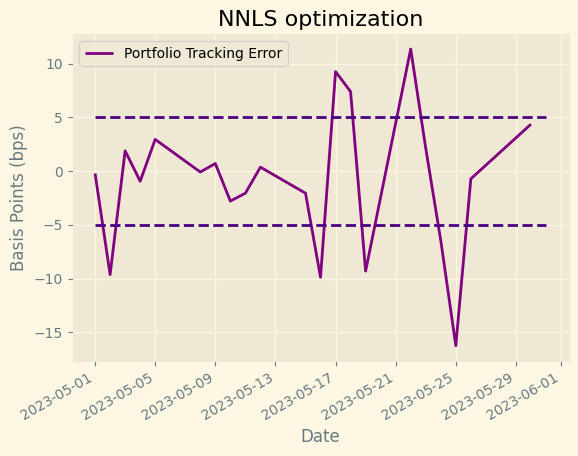


Portfolio Evaluation - NNLS
--------------------------------------------------
Standard Tracking Error: 5.6394 bps
Information Ratio: -0.4035
Portfolio Active Return: -0.0228 %
--------------------------------------------------


In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import nnls

# training with Non-Negative Least Squares (NNLS)
NNLS_residual = nnls(X, Y['^DJI'])
NNLS_leverage = sum(NNLS_residual[0])
NNLS_weights = dict(zip(X.columns, NNLS_residual[0] / NNLS_leverage))
NNLS_allocation = pd.DataFrame({'Component': list(NNLS_weights.keys()),
                                'NNLS-30wg(%)': np.multiply(list(NNLS_weights.values()), 100)}).sort_values('NNLS-30wg(%)', ascending=False)
NNLS_allocation.set_index('Component', inplace=True)
NNLS_allocation.reset_index(inplace=True)

# testing NNLS portfolio optimization
Opt['NNLS'] = NNLS_leverage * X.dot(list(NNLS_weights.values()))
evaluate(Opt, 'NNLS')

# PCRR.py


---


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=d179a9d06f6b23f74a4dd0681ede0a340d35a6c79b02c6e5b0b47b454bbdcbdd
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


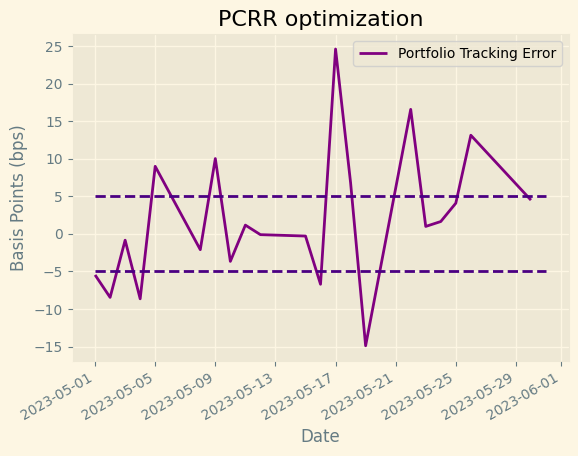


Portfolio Evaluation - PCRR
--------------------------------------------------
Standard Tracking Error: 7.953 bps
Information Ratio: 65.8475
Portfolio Active Return: 5.2368 %
--------------------------------------------------


In [3]:
!pip install pingouin
import pingouin as pg

# portfolio allocation with Partial Correlation (PCRR)
PCRR_correls = pd.DataFrame({'corr': pd.merge(X, Y, on='Date').corr()['^DJI'],
                             'pcorr': pd.merge(X, Y, on='Date').pcorr()['^DJI']})
PCRR_leverage = sum(PCRR_correls['pcorr'].drop('^DJI'))
PCRR_weights = (PCRR_correls['pcorr'].drop('^DJI') / PCRR_leverage).to_dict()
PCRR_allocation = pd.DataFrame({'Component': list(PCRR_weights.keys()),
                                'PCRR-30wg(%)': np.multiply(list(PCRR_weights.values()), 100)}).sort_values('PCRR-30wg(%)', ascending=False)
PCRR_allocation.set_index('Component', inplace=True)
PCRR_allocation.reset_index(inplace=True)

# PCRR portfolio optimization evaluation
Opt['PCRR'] = PCRR_leverage * X.dot(list(PCRR_weights.values()))
evaluate(Opt, 'PCRR')

# DTW.py


---



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.3/368.3 kB 15.3 MB/s eta 0:00:00


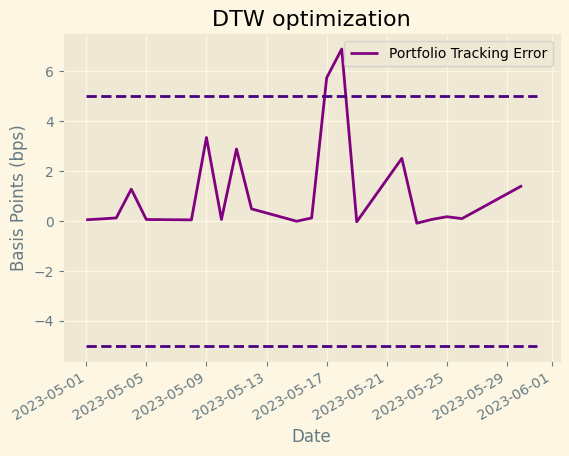


Portfolio Evaluation - DTW
--------------------------------------------------
Standard Tracking Error: 1.7922 bps
Information Ratio: 356.9851
Portfolio Active Return: 6.398 %
--------------------------------------------------


In [4]:
from scipy import optimize
!pip install tslearn
from tslearn.metrics import dtw

# portfolio allocation with Dynamic Time Warping (DTW)
DTW_distances = X.apply(lambda x: dtw(x, Y))
DTW_weights = (1 / DTW_distances / sum(1 / DTW_distances)).to_dict()
DTW_allocation = pd.DataFrame({'Component': list(DTW_weights.keys()),
                                    'DTW-30wg(%)': np.multiply(list(DTW_weights.values()), 100)}).sort_values('DTW-30wg(%)', ascending=False)
DTW_allocation.set_index('Component', inplace=True)
DTW_allocation.reset_index(inplace=True)

# DTW portfolio optimization evaluation
Opt['DTW'] = X.dot(list(DTW_weights.values()))
evaluate(Opt, 'DTW')

# NNMF.py


---



/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


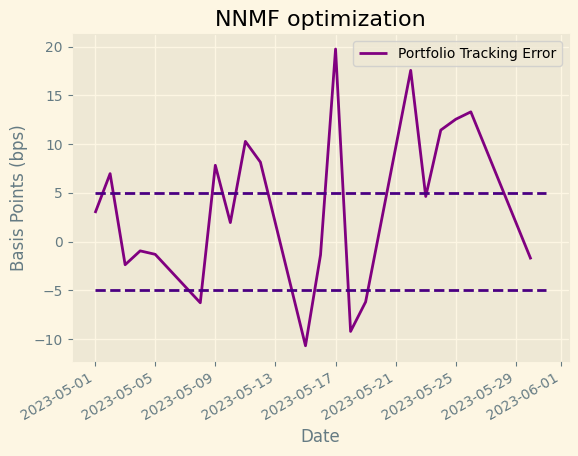


Portfolio Evaluation - NNMF
--------------------------------------------------
Standard Tracking Error: 14.352 bps
Information Ratio: 83.2468
Portfolio Active Return: 11.9475 %
--------------------------------------------------


In [5]:
from sklearn.decomposition import NMF

# portfolio allocation with Non-Negative Matrix Factorization (NNMF)
NNMF_coeffs = NMF(n_components=1).fit(X).components_.tolist()[0]
NNMF_weights = dict(zip(list(X.columns), np.divide(NNMF_coeffs, sum(NNMF_coeffs))))
NNMF_allocation = pd.DataFrame({'Component': list(NNMF_weights.keys()),
                                     'NNMF-30wg(%)': np.multiply(list(NNMF_weights.values()),100)}).sort_values('NNMF-30wg(%)', ascending=False)
NNMF_allocation.set_index('Component', inplace=True)
NNMF_allocation.reset_index(inplace=True)

# NNMF optimization evaluation
Opt['NNMF'] = X.dot(list(NNMF_weights.values()))
evaluate(Opt,'NNMF')

# PSO.py


---



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.5 MB/s eta 0:00:00


2023-07-04 19:16:15,956 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1, 'w': 0.4}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=1.87e+3
2023-07-04 19:16:36,815 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1869.6224446229353, best pos: [0.9965222  0.99827308 0.98611455 0.98559664 0.99428928 0.99888328
 0.92728939 0.97680087 0.99368799 0.99550196 0.99951093 0.99231966
 0.9970684  0.99847801 0.99983128 0.99683543 0.99973172 0.99689698
 0.99191205 0.99398473 0.99759566 0.99564876 0.99833386 0.99057557
 0.98225009 0.99835399 0.99854753 0.96222074 0.99512511 0.98571904]
2023-07-04 19:16:36,834 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 1.5, 'c2': 1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=1.87e+3
2023-07-04 19:17:02,948 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1870.1425480454354, best pos: [0.99710845 0.998828

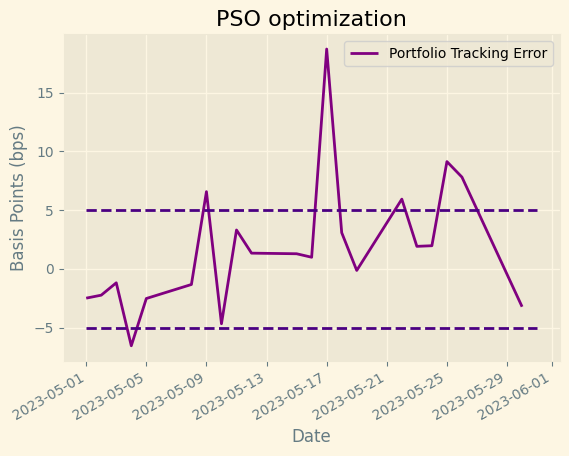


Portfolio Evaluation - PSO
--------------------------------------------------
Standard Tracking Error: 6.4503 bps
Information Ratio: 160.9208
Portfolio Active Return: 10.3799 %
--------------------------------------------------


In [6]:
!pip install pyswarms
from pyswarms.utils.search.grid_search import GridSearch
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.plotters.plotters import plot_cost_history

# portfolio allocation with Particle Swarm (PSO)
def train_particle_loss(coeffs):
    benchmark_tracking_error = np.std(X.dot(coeffs) - Y['^DJI'])
    return benchmark_tracking_error

def train_swarm(x):
    n_particles = x.shape[0]
    particle_loss = [train_particle_loss(x[i]) for i in range(n_particles)]
    return particle_loss

g = GridSearch(GlobalBestPSO,
                     objective_func=train_swarm,
                     n_particles=100,
                     dimensions=len(X.columns),
                     options={'c1': [1.5, 2.5], 'c2': [1, 2], 'w': [0.4, 0.5]},
                     bounds=(len(X.columns) * [0],
                             len(X.columns) * [1]),
                     iters=100)

best_cost, best_pos = g.search() # Given a matrix of position options search for best position

optimizer = GlobalBestPSO(n_particles=1000,
                                dimensions=len(X.columns),
                                options=best_pos,
                                bounds=(len(X.columns) * [0],
                                        len(X.columns) * [1]))

cost, pos = optimizer.optimize(train_swarm, iters=100) # Given the best position option optimize the cost

PSO_leverage = sum(pos)
PSO_weights = dict(zip(list(X.columns), list(pos / PSO_leverage)))
PSO_allocation = pd.DataFrame({'Component': X.columns,
                                    'PSO-30wg(%)': np.multiply(list(PSO_weights.values()), 100)}).sort_values('PSO-30wg(%)', ascending=False)
PSO_allocation.set_index('Component', inplace=True)
PSO_allocation.reset_index(inplace=True)

# PSW portfolio optimization evaluation
Opt['PSO'] = PSO_leverage * X.dot(list(PSO_weights.values()))
evaluate(Opt, 'PSO')

# Results & learning a model

Quick premise to the results: even if some optimization methods had better tracking errors than others, **I am assuming that it is desirable to combine them all in order to have a robust strategy**. Apart from the picture, I chose to represent the results with three different tables.

* The first is also the simplest; it is just a list of the optimization methods, sorted by their own standard tracking error. As you can see, **being the most demanding method of the five (the PSO) does not grant the best performance**.

* The second table represents a summary of the portfolios broken down by single stocks. **Negative-weighted stocks are those that appear to be negatively correlated with the index and therefore should be bought short**. Indeed, all the weights in a portfolio always sum up to 100%.

* The last table shows the tracking error time series by optimization methods. **I decided to set up an interval of +/- 5 bps, within which the replica can be considered correct, to evaluate the mean of the tracking errors day by day**. I have also created a boolean variable to express this latter information.

Starting from this basis, I trained two models (the ML model and the DL model) to generate forecasts of the boolean variable, using the tracking errors of only 4 of the 5 portfolio optimization methods as predictors.

**I intentionally excluded PSO because it is the most expensive in terms of time and computational resources**. The ultimate goal is to compare models that can generate predictions based on the tracking errors of four optimization methods without the need for input from the fifth method (the PSO).

**If the models prove reliable, their predictions on a completely new dataset could be interpreted as if they were generated using information from PSO as well**. Even if, in reality, PSO was not actually applied to the new data, which would lead to a significant saving of resources.

# results.py


---



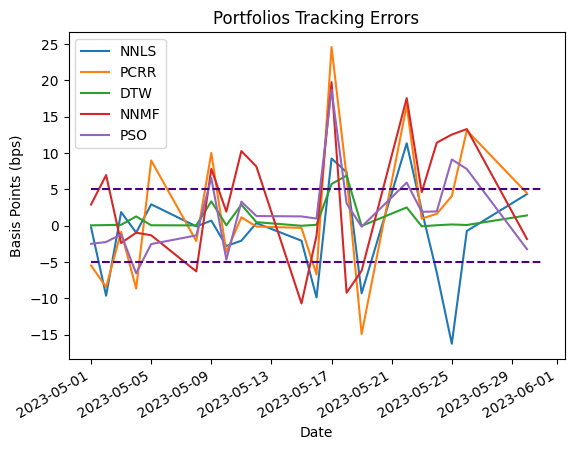

----------------------------------------------------------------------------------------------------


,Opt_Method,Std_Tracking_Errors
2,DTW,1.7922
0,NNLS,5.6394
4,PSO,6.4503
1,PCRR,7.9530
3,NNMF,14.3520


----------------------------------------------------------------------------------------------------


,Component,NNLS-30wg(%),PCRR-30wg(%),DTW-30wg(%),NNMF-30wg(%),PSO-30wg(%)
0,VZ,7.500466,2.779822,3.321591,0.946170,1.686920
1,MMM,6.068663,4.549663,3.331663,2.983470,2.710036
2,PG,4.793215,3.399867,3.330934,2.852862,2.991351
3,INTC,4.791241,2.550516,3.321219,0.867861,2.235906
4,WMT,4.728840,4.165222,3.330878,2.838172,2.329167
5,DIS,4.412503,4.554946,3.330901,2.824399,3.428124
6,JPM,4.082901,3.230134,3.330322,2.724834,4.137016
7,WBA,4.012975,1.955851,3.321009,0.829240,3.222276
8,AMGN,3.968516,4.515977,3.339987,4.685781,2.291762
9,CRM,3.759302,4.936972,3.338376,4.335789,2.901905


----------------------------------------------------------------------------------------------------


,NNLS,PCRR,DTW,NNMF,PSO,Mean,Replica
Date,,,,,,,
2020-09-02,-3.1319,-10.8061,0.1993,2.5048,3.5433,-1.53812,True
2020-09-03,6.9199,-11.3442,-2.6328,-5.6791,5.1919,-1.50886,True
2020-09-04,-6.7637,-11.0459,-1.5041,-14.5109,2.3038,-6.30416,False
2020-09-08,5.9063,-12.9697,-2.6853,-4.2456,1.5599,-2.48688,True
2020-09-09,-0.2602,10.2784,3.3075,14.4235,1.2676,5.80336,False
...,...,...,...,...,...,...,...
2023-05-23,2.1183,0.9822,-0.0856,4.6196,1.9123,1.90936,True
2023-05-24,-6.4518,1.6346,0.0667,11.4307,1.9655,1.72914,True
2023-05-25,-16.2453,4.0755,0.1743,12.5457,9.1239,1.93482,True


In [7]:
# creating final results dataframes
Opt_methods = pd.DataFrame(opt_terrors.items(), columns=['Opt_Method', 'Std_Tracking_Errors']).sort_values('Std_Tracking_Errors', ascending=True)

Opt_portfolios = pd.merge(pd.merge(pd.merge(pd.merge(NNLS_allocation, PCRR_allocation, on='Component', how='outer'),
                                            DTW_allocation, on='Component', how='outer'),
                                   NNMF_allocation, on='Component', how='outer'),
                          PSO_allocation, on='Component', how='outer').fillna(0)

# showing results
plt.style.use('default')

TErrors = pd.DataFrame()
TErrors['NNLS'] = round((Opt['NNLS'].pct_change().dropna() - Opt['^DJI'].pct_change().dropna()) * 10000, 4)
TErrors['PCRR'] = round((Opt['PCRR'].pct_change().dropna() - Opt['^DJI'].pct_change().dropna()) * 10000, 4)
TErrors['DTW'] = round((Opt['DTW'].pct_change().dropna() - Opt['^DJI'].pct_change().dropna()) * 10000, 4)
TErrors['NNMF'] = round((Opt['NNMF'].pct_change().dropna() - Opt['^DJI'].pct_change().dropna()) * 10000, 4)
TErrors['PSO'] = round((Opt['PSO'].pct_change().dropna() - Opt['^DJI'].pct_change().dropna()) * 10000, 4)
TErrors[(TErrors.index >= pd.to_datetime('2023-05-01')) & (TErrors.index <= pd.to_datetime('2023-05-31'))].plot()
TErrors['Mean'] = TErrors.mean(axis=1)
TErrors['Replica'] = (abs(TErrors['Mean']) < 5).astype(bool)

plt.title(f"Portfolios Tracking Errors")
plt.ylabel('Basis Points (bps)')
plt.hlines(y = 5, xmin = "2023-05-01", xmax = "2023-05-31", colors='indigo', linestyle='dashed')
plt.hlines(y = -5, xmin = "2023-05-01", xmax = "2023-05-31", colors='indigo', linestyle='dashed')
plt.show()

print("-" * 100)
display(Opt_methods)
print("-" * 100)
display(Opt_portfolios)
print("-" * 100)
display(TErrors)

# learning.py


---



In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import time

train_TE = TErrors[(TErrors.index >= pd.to_datetime('2020-09-01')) & (TErrors.index <= pd.to_datetime('2022-12-31'))]
test_TE = TErrors[(TErrors.index >= pd.to_datetime('2023-01-01')) & (TErrors.index <= pd.to_datetime('2023-05-31'))]
epochs = 20
predictors = ['NNLS', 'PCRR', 'DTW', 'NNMF']

# ML modelling
ml_model = RandomForestClassifier(n_estimators=100, min_samples_split=50, random_state=1)
ml_model.fit(train_TE[predictors], train_TE['Replica'])

# DL modelling
dl_model = Sequential()
dl_model.add(Dense(16, input_shape=(4,), activation='relu'))
dl_model.add(Dense(4, activation='relu'))
dl_model.add(Dense(1, activation='sigmoid'))
dl_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
t1 = time.time()
dl_model.fit(train_TE[predictors], train_TE['Replica'], epochs=epochs, batch_size=10)
t2 = time.time()
print("-" * 100)
print('Elapsed seconds per epoch: {:.5f}'.format((t2 - t1)/epochs))
dl_model.summary()

replica_preds = pd.DataFrame()
replica_preds['Ground_Truth'] = test_TE[['Replica']]
replica_preds['ML_preds'] = pd.Series(ml_model.predict(test_TE[predictors]), index = test_TE.index)
replica_preds['DL_preds'] = (dl_model.predict(test_TE[predictors]) > 0.5).astype(bool)

print("-" * 100)
display(replica_preds)
print("-" * 100)
print('ML accuracy score:', precision_score(replica_preds['Ground_Truth'], replica_preds['ML_preds']))
print("-" * 100)
print('DL accuracy score:', precision_score(replica_preds['Ground_Truth'], replica_preds['DL_preds']))

Epoch 1/20
59/59 [==============================] - 1s 2ms/step - loss: 0.8146 - accuracy: 0.5639
Epoch 2/20
59/59 [==============================] - 0s 2ms/step - loss: 0.5736 - accuracy: 0.7206
Epoch 3/20
59/59 [==============================] - 0s 2ms/step - loss: 0.5171 - accuracy: 0.7496
Epoch 4/20
59/59 [==============================] - 0s 2ms/step - loss: 0.4792 - accuracy: 0.7700
Epoch 5/20
59/59 [==============================] - 0s 2ms/step - loss: 0.4474 - accuracy: 0.7853
Epoch 6/20
59/59 [==============================] - 0s 2ms/step - loss: 0.4268 - accuracy: 0.7922
Epoch 7/20
59/59 [==============================] - 0s 2ms/step - loss: 0.4048 - accuracy: 0.8024
Epoch 8/20
59/59 [==============================] - 0s 2ms/step - loss: 0.3884 - accuracy: 0.8143
Epoch 9/20
59/59 [==============================] - 0s 2ms/step - loss: 0.3742 - accuracy: 0.8075
Epoch 10/20
59/59 [==============================] - 0s 5ms/step - loss: 0.3610 - accuracy: 0.8160
Epoch 11/20
59/59 [

,Ground_Truth,ML_preds,DL_preds
Date,,,
2023-01-03,True,False,True
2023-01-04,False,False,True
2023-01-05,False,False,True
2023-01-06,False,False,True
2023-01-09,False,False,False
...,...,...,...
2023-05-23,True,True,True
2023-05-24,True,True,True
2023-05-25,True,True,True


----------------------------------------------------------------------------------------------------
ML accuracy score: 0.9466666666666667
----------------------------------------------------------------------------------------------------
DL accuracy score: 0.8390804597701149
